In [2]:
!pip install -qU langchain langchain-community langchain-groq langchain-core langchain-pinecone  langgraph sentence-transformers\
                langchain-huggingface groq langchain pinecone-client PyPDF2

!pip install pypdf2

!pip install pydantic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.9/399.9 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.8/244.8 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


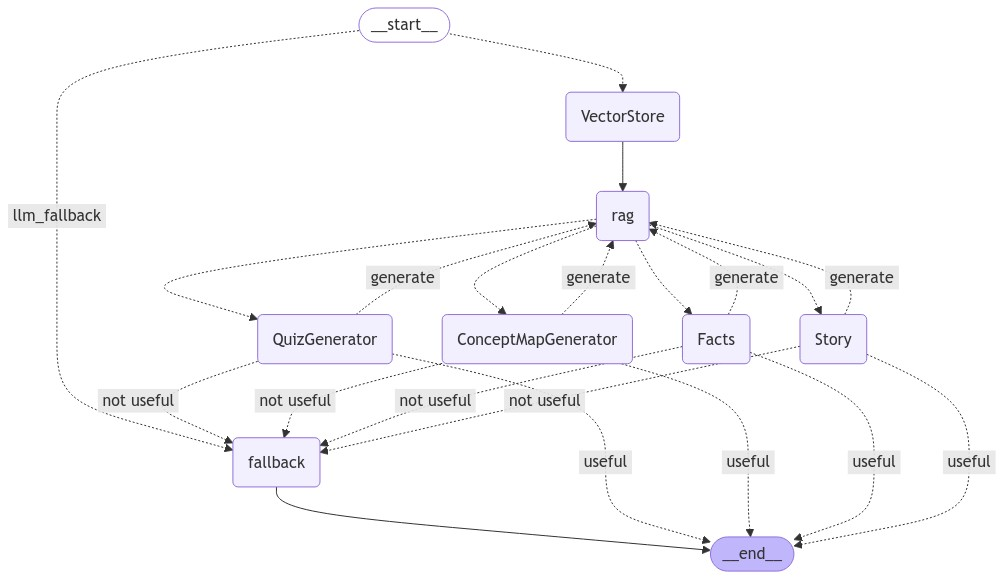

KeyError: 'VectorStore'

In [27]:
# -*- coding: utf-8 -*-
import os
from typing import List, Optional
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableParallel
from langchain_core.messages import HumanMessage, AIMessage
import PyPDF2
from sentence_transformers import SentenceTransformer
from langchain_pinecone import PineconeVectorStore
from langchain_core.documents import Document
from pinecone import Pinecone
from pydantic import BaseModel, Field
from typing import Literal
from operator import itemgetter
from IPython.core.display import Markdown
from langchain_groq import ChatGroq

# Set up API Keys
os.environ["PINECONE_API_KEY"] = "534349d3-964c-4282-a45c-6a5a23ec8764"
os.environ['GROQ_API_KEY'] = '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'

# Initialize Pinecone and the HuggingFace embedding model
api_key = os.environ.get("PINECONE_API_KEY")
pc = Pinecone(api_key=api_key, environment="us-east-1-aws")
vectorstore_from_docs = pc.Index("sarvamaisumarry")
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

# Define Retriever class
class Retriever:
    def __init__(self, vectorstore, embedding_model):
        self.vecstore = vectorstore
        self.embedding_model = embedding_model

    def sim_search(self, query):
        query_vector = self.embedding_model.embed_query(query)
        response = self.vecstore.query(
            vector=query_vector,
            top_k=5,
            include_metadata=True
        )
        # Convert the retrieved matches into Document instances
        documents = [
            Document(page_content=match['metadata']['text'], metadata={"source": match['metadata']})
            for match in response['matches']
        ]
        return documents

retriever = Retriever(vectorstore_from_docs, embedding_model)

# Define the VectorStore query action
class VectorStore(BaseModel):
    query: str

# Router prompt template for deciding on actions
router_prompt_template = (
    "You are an expert in routing user queries to a VectorStore\n"
    "The VectorStore contains Educational Data.\n"
    'Note that if a query is not chapter-related, you must output "not context related".\n\n'
    "query: {query}"
)

llm = ChatGroq(model="llama-3.1-70b-versatile", temperature=0)
prompt = ChatPromptTemplate.from_template(router_prompt_template)
question_router = prompt | llm.bind_tools(tools=[VectorStore])

# Tool for quiz-based questions
class QuizGenerator(BaseModel):
    query: str

quiz_prompt_template = (
    "You are a quiz generator. Provide a list of 5 questions based on the user's query.\n\n"
    "query: {query}"
)
quiz_prompt = ChatPromptTemplate.from_template(quiz_prompt_template)
quiz_chain = quiz_prompt | llm | StrOutputParser()

class ConceptMapGenerator(BaseModel):
    query: str

concept_map_prompt_template = (
    "You are a concept map generator. Provide a structured concept map based on the user's query.\n\n"
    "query: {query}"
)

concept_map_prompt = ChatPromptTemplate.from_template(concept_map_prompt_template)
concept_map_chain = concept_map_prompt | llm | StrOutputParser()

class Facts(BaseModel):
    query: str

concept_map_prompt_template = (
    "You are a bot which generates Interesting facts. Provide Interesting facts based on the user's query.\n\n"
    "query: {query}"
)

concept_map_prompt = ChatPromptTemplate.from_template(concept_map_prompt_template)
concept_map_chain = concept_map_prompt | llm | StrOutputParser()

story_prompt_template = (
    "You are a creative educational storyteller who provides education in a creative way. Generate a short story based on the user's prompt.\n\n"
    "prompt: {prompt}"
)
story_prompt = ChatPromptTemplate.from_template(story_prompt_template)
story_chain = story_prompt | llm | StrOutputParser()

# Adding tools
tool_executor = RunnableParallel({
    "VectorStore": retriever.sim_search,
    "QuizGenerator": quiz_chain.invoke,
    "ConceptMapGenerator": concept_map_chain.invoke,
    "Facts": concept_map_chain.invoke,
    "Story": story_chain.invoke
})

# Agent state to store information
class AgentState(BaseModel):
    query: str
    chat_history: List[HumanMessage] = []
    generation: Optional[str] = None
    documents: Optional[List[Document]] = None

# Node to route the question
def question_router_node(state: AgentState) -> str:
    query = state.query
    try:
        response = question_router.invoke({"query": query})
    except Exception:
        return "llm_fallback"

    if "tool_calls" not in response.additional_kwargs:
        print("---No tool called---")
        return "llm_fallback"

    return "VectorStore"

# Node to retrieve relevant documents from VectorStore
def retrieve_node(state: AgentState) -> dict[str, Optional[List[Document]]]:
    query = state.query
    documents = retriever.sim_search(query)
    return {"documents": documents}

# Fallback when no tool is applicable
def fallback_node(state: AgentState):
    query = state.query
    chat_history = state.chat_history
    generation = fallback_chain.invoke({"query": query, "chat_history": chat_history})
    return {"generation": generation}

# Node to call the RAG model
def rag_node(state: AgentState):
    query = state.query
    documents = state.documents
    generation = rag_chain.invoke({"query": query, "context": documents})
    return {"generation": generation}

# Fallback prompt for handling non-educational queries
fallback_prompt = ChatPromptTemplate.from_template(
    (
        "You are a well-renowned agent your name is 'RAG'.\n"
        "Do not respond to queries that are not related to education.\n"
        "If a query is not related to education, acknowledge your limitations.\n"
        "Provide concise responses to only education-related queries.\n\n"
        "Current conversations:\n\n{chat_history}\n\n"
        "human: {query}"
    )
)

fallback_chain = (
    {
        "chat_history": lambda x: "\n".join(
            [
                f"human: {msg.content}" if isinstance(msg, HumanMessage) else f"AI: {msg.content}"
                for msg in x["chat_history"]
            ]
        ),
        "query": itemgetter("query"),
    }
    | fallback_prompt
    | llm
    | StrOutputParser()
)

# RAG template for fetching relevant documents and generating response
rag_template_str = (
    "You are a helpful assistant. Answer the query below based on the provided context.\n\n"
    "context: {context}\n\n"
    "query: {query}"
)

rag_prompt = ChatPromptTemplate.from_template(rag_template_str)
rag_chain = rag_prompt | llm | StrOutputParser()

# Workflow for deciding whether to use VectorStore or fallback
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)
workflow.add_node("VectorStore", retrieve_node)
workflow.add_node("rag", rag_node)
workflow.add_node("QuizGenerator", quiz_chain.invoke)
workflow.add_node("ConceptMapGenerator", concept_map_chain.invoke)
workflow.add_node("Facts", concept_map_chain.invoke)
workflow.add_node("Story", story_chain.invoke)
workflow.add_node("fallback", fallback_node)

workflow.set_conditional_entry_point(
    question_router_node,
    {
        "llm_fallback": "fallback",
        "VectorStore": "VectorStore",
    },
)

workflow.add_edge("VectorStore", "rag")

workflow.add_conditional_edges(
    "rag",
    question_router_node,
    {
        "QuizGenerator": "QuizGenerator",
        "ConceptMapGenerator": "ConceptMapGenerator",
        "Facts": "Facts",
        "Story": "Story"
    },
)

workflow.add_conditional_edges(
    "QuizGenerator",
    question_router_node,
    {
        "useful": END,
        "not useful": "fallback",
        "generate": "rag"
    }
)

# Repeat the above for other tools if they have similar transitions
workflow.add_conditional_edges(
    "ConceptMapGenerator",
    question_router_node,
    {
        "useful": END,
        "not useful": "fallback",
        "generate": "rag"
    }
)

workflow.add_conditional_edges(
    "Facts",
    question_router_node,
    {
        "useful": END,
        "not useful": "fallback",
        "generate": "rag"
    }
)

workflow.add_conditional_edges(
    "Story",
    question_router_node,
    {
        "useful": END,
        "not useful": "fallback",
        "generate": "rag"
    }
)

workflow.add_edge("fallback", END)

app = workflow.compile(debug=False)

from PIL import Image
from IPython.display import display
from io import BytesIO

plot = app.get_graph().draw_mermaid_png()
img = Image.open(BytesIO(plot))
display(img)

# Example invocation
response = app.invoke({
    "query": "Generate quiz questions for me",
    "chat_history": [],
    "generation": None,
    "documents": None
})

Markdown(response["generation"])


In [59]:
# -*- coding: utf-8 -*-
import os
from typing import List, Optional
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableParallel
from langchain_core.messages import HumanMessage, AIMessage
import PyPDF2
from sentence_transformers import SentenceTransformer
from langchain_pinecone import PineconeVectorStore
from langchain_core.documents import Document
from pinecone import Pinecone
from pydantic import BaseModel, Field
from typing import Literal
from operator import itemgetter
from IPython.core.display import Markdown
from langchain_groq import ChatGroq

# Set up API Keys
os.environ["PINECONE_API_KEY"] = "534349d3-964c-4282-a45c-6a5a23ec8764"
os.environ['GROQ_API_KEY'] = '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'

# Initialize Pinecone and the HuggingFace embedding model
api_key = os.environ.get("PINECONE_API_KEY")
pc = Pinecone(api_key=api_key, environment="us-east-1-aws")
vectorstore_from_docs = pc.Index("sarvamaisumarry")
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

# Define Retriever class
class Retriever:
    def __init__(self, vectorstore, embedding_model):
        self.vecstore = vectorstore
        self.embedding_model = embedding_model

    def sim_search(self, query):
        query_vector = self.embedding_model.embed_query(query)
        response = self.vecstore.query(
            vector=query_vector,
            top_k=5,
            include_metadata=True
        )
        # Convert the retrieved matches into Document instances
        documents = [
            Document(page_content=match['metadata']['text'], metadata={"source": match['metadata']})
            for match in response['matches']
        ]
        return documents

retriever = Retriever(vectorstore_from_docs, embedding_model)

# Define the VectorStore query action
class VectorStore(BaseModel):
    query: str

# Router prompt template for deciding on actions
router_prompt_template = (
    "You are an expert in routing user queries to appropriate tools.\n"
    "If the user greets you, route to 'llm_fallback'.\n"
    "If the user asks for information retrieval, route to the 'VectorStore'.\n"
    "If the user asks for generating a quiz, route to the 'QuizGenerator'.\n"
    "If the user asks for creating a concept map, route to the 'ConceptMapGenerator'.\n"
    "If the user asks for facts, route to 'Facts'.\n"
    "If the user asks for a story, route to 'Story'.\n"
    "Otherwise, output 'llm_fallback'.\n\n"
    "query: {query}"
)

llm = ChatGroq(model="llama-3.1-70b-versatile", temperature=0)
prompt = ChatPromptTemplate.from_template(router_prompt_template)
question_router = prompt | llm.bind_tools(tools=[VectorStore])

# Tool for quiz-based questions
class QuizGenerator(BaseModel):
    query: str

quiz_prompt_template = (
    "You are a quiz generator. Provide a list of 5 questions based on the user's query.\n\n"
    "query: {query}"
)
quiz_prompt = ChatPromptTemplate.from_template(quiz_prompt_template)
quiz_chain = quiz_prompt | llm | StrOutputParser()

class ConceptMapGenerator(BaseModel):
    query: str

concept_map_prompt_template = (
    "You are a concept map generator. Provide a structured concept map based on the user's query.\n\n"
    "query: {query}"
)

concept_map_prompt = ChatPromptTemplate.from_template(concept_map_prompt_template)
concept_map_chain = concept_map_prompt | llm | StrOutputParser()

class Facts(BaseModel):
    query: str

fact_prompt_template = (
    "You are a bot which generates Interesting facts. Provide Interesting facts based on the user's query.\n\n"
    "query: {query}"
)

fact_prompt = ChatPromptTemplate.from_template(fact_prompt_template)
fact_chain = fact_prompt | llm | StrOutputParser()

story_prompt_template = (
    "You are a creative educational storyteller who provides education in a creative way. Generate a short story based on the user's prompt.\n\n"
    "prompt: {prompt}"
)
story_prompt = ChatPromptTemplate.from_template(story_prompt_template)
story_chain = story_prompt | llm | StrOutputParser()

# Adding tools
tool_executor = RunnableParallel({
    "VectorStore": retriever.sim_search,
    "QuizGenerator": quiz_chain.invoke,
    "ConceptMapGenerator": concept_map_chain.invoke,
    "Facts": concept_map_chain.invoke,
    "Story": story_chain.invoke
})

# Agent state to store information
class AgentState(BaseModel):
    query: str
    chat_history: List[HumanMessage] = []
    generation: Optional[str] = None
    documents: Optional[List[Document]] = None

# Node to route the question
def question_router_node(state: AgentState) -> str:
    query = state.query
    try:
        response = question_router.invoke({"query": query})
    except Exception as e:
        print(f"Error in question_router.invoke: {e}")
        return "llm_fallback"

    # Print the structure of additional_kwargs to inspect the content
    print("---Response additional_kwargs---")
    print(response.additional_kwargs)

    # Ensure that tool_calls exists and is a list with at least one element
    tool_calls = response.additional_kwargs.get("tool_calls", None)

    if tool_calls is None or not isinstance(tool_calls, list) or len(tool_calls) == 0:
        print("---No tool calls found---")
        return "llm_fallback"

    tool_call = tool_calls[0]

    # Check if "name" key exists in the tool_call
    if "name" not in tool_call:
        print("---No 'name' key found in the tool_call---")
        return "llm_fallback"

    tool_name = tool_call["name"]

    # Now route based on tool_name
    if tool_name == "VectorStore":
        return "VectorStore"
    elif tool_name == "QuizGenerator":
        return "QuizGenerator"
    elif tool_name == "ConceptMapGenerator":
        return "ConceptMapGenerator"
    elif tool_name == "Facts":
        return "Facts"
    elif tool_name == "Story":
        return "Story"
    else:
        print(f"---Unknown tool_name: {tool_name}---")
        return "llm_fallback"

# Node to retrieve relevant documents from VectorStore
def retrieve_node(state: AgentState) -> dict[str, Optional[List[Document]]]:
    query = state.query
    documents = retriever.sim_search(query)
    return {"documents": documents}

# Fallback when no tool is applicable
def fallback_node(state: AgentState):
    query = state.query
    chat_history = state.chat_history
    generation = fallback_chain.invoke({"query": query, "chat_history": chat_history})
    return {"generation": generation}

# Node to call the RAG model
def rag_node(state: AgentState):
    query = state.query
    documents = state.documents
    generation = rag_chain.invoke({"query": query, "context": documents})
    return {"generation": generation}


# Fallback prompt for handling non-educational queries
fallback_prompt = ChatPromptTemplate.from_template(
    (
        "You are a well-renowned agent your name is 'RAG'.\n"
        "Do not respond to queries that are not related to education.\n"
        "If a query is not related to education, acknowledge your limitations.\n"
        "Provide concise responses to only education-related queries.\n\n"
        "Current conversations:\n\n{chat_history}\n\n"
        "human: {query}"
    )
)

fallback_chain = (
    {
        "chat_history": lambda x: "\n".join(
            [
                f"human: {msg.content}" if isinstance(msg, HumanMessage) else f"AI: {msg.content}"
                for msg in x["chat_history"]
            ]
        ),
        "query": itemgetter("query"),
    }
    | fallback_prompt
    | llm
    | StrOutputParser()
)

# RAG template for fetching relevant documents and generating response
rag_template_str = (
    "You are a helpful assistant. Answer the query below based on the provided context.\n\n"
    "context: {context}\n\n"
    "query: {query}"
)

rag_prompt = ChatPromptTemplate.from_template(rag_template_str)
rag_chain = rag_prompt | llm | StrOutputParser()

# Workflow for deciding whether to use VectorStore or fallback
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)
workflow.add_node("VectorStore", retrieve_node)
workflow.add_node("rag", rag_node)
workflow.add_node("fallback", fallback_node)
workflow.add_node("QuizGenerator", lambda state: {"generation": quiz_chain.invoke({"query": state.query})})
workflow.add_node("ConceptMapGenerator", lambda state: {"generation": concept_map_chain.invoke({"query": state.query})})
workflow.add_node("Facts", lambda state: {"generation": fact_chain.invoke({"query": state.query})})
workflow.add_node("Story", lambda state: {"generation": story_chain.invoke({"query": state.query})})

workflow.set_conditional_entry_point(
    question_router_node,
    {
        "llm_fallback": "fallback",
        "VectorStore": "VectorStore",
        "QuizGenerator": "QuizGenerator",
        "ConceptMapGenerator": "ConceptMapGenerator",
        "Facts": "Facts",
        "Story": "Story",
    },
)

workflow.add_edge("VectorStore", "rag")

# Then, handle the next part of the conditional workflow, which is for useful/not-useful transitions
workflow.add_conditional_edges(
    "QuizGenerator",
    question_router_node,
    {
        "useful": END,
        "not useful": "fallback",
        "generate": "rag"
    }
)

# Repeat the above for other tools if they have similar transitions
workflow.add_conditional_edges(
    "ConceptMapGenerator",
    question_router_node,
    {
        "useful": END,
        "not useful": "fallback",
        "generate": "rag"
    }
)

workflow.add_conditional_edges(
    "Facts",
    question_router_node,
    {
        "useful": END,
        "not useful": "fallback",
        "generate": "rag"
    }
)

workflow.add_conditional_edges(
    "Story",
    question_router_node,
    {
        "useful": END,
        "not useful": "fallback",
        "generate": "rag"
    }
)
workflow.add_edge("fallback", END)

app = workflow.compile(debug=False)

# Example invocation
response = app.invoke({
    "query": "Hello",
    "chat_history": [],
    "generation": None,
    "documents": None
})

Markdown(response["generation"])


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


---Response additional_kwargs---
{'tool_calls': [{'id': 'call_zmcf', 'function': {'arguments': '{"query": "Hello"}', 'name': 'llm_fallback'}, 'type': 'function'}]}
---No 'name' key found in the tool_call---


Hello, I'm RAG, an education specialist. How can I assist you with your educational queries?

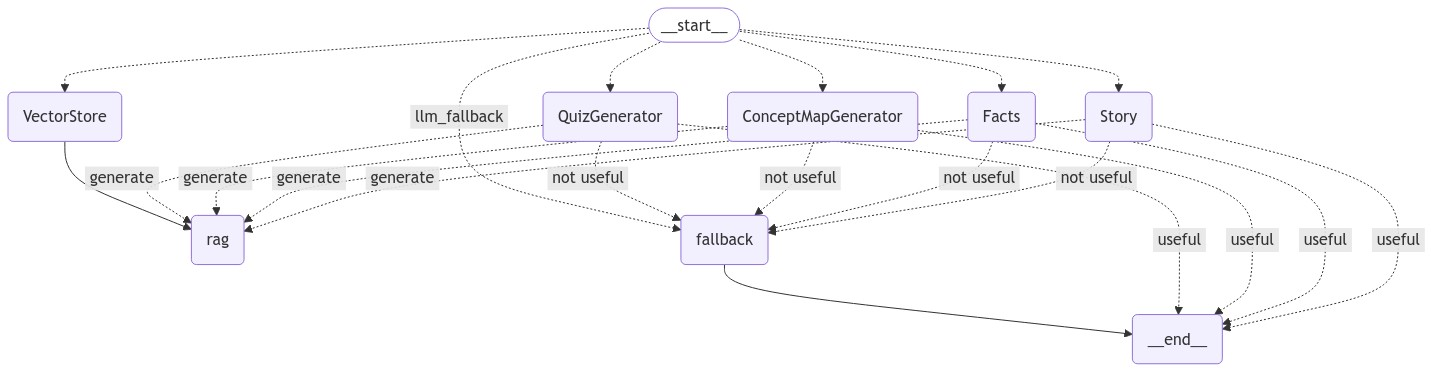

In [60]:
from PIL import Image
from IPython.display import display
from io import BytesIO

plot = app.get_graph().draw_mermaid_png()
img = Image.open(BytesIO(plot))
display(img)

In [56]:
response = question_router.invoke("Hi")
print("Router Response:", response)

Router Response: content='' additional_kwargs={'tool_calls': [{'id': 'call_n7t1', 'function': {'arguments': '{"query": "Hi"}', 'name': 'llm_fallback'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 312, 'total_tokens': 329, 'completion_time': 0.068, 'prompt_time': 0.104346514, 'queue_time': 0.005216664999999995, 'total_time': 0.172346514}, 'model_name': 'llama-3.1-70b-versatile', 'system_fingerprint': 'fp_b6828be2c9', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-0437ff6c-2cb3-43ad-8b41-0ffdbf9a8681-0' tool_calls=[{'name': 'llm_fallback', 'args': {'query': 'Hi'}, 'id': 'call_n7t1', 'type': 'tool_call'}] usage_metadata={'input_tokens': 312, 'output_tokens': 17, 'total_tokens': 329}


In [50]:
response = app.invoke({
    "query": "Hi",
    "chat_history": [],
    "generation": None,
    "documents": None
})

Markdown(response["generation"])

Hello. How can I assist you with the provided text about sound?

In [47]:
response = app.invoke({
    "query": "Provide a educational learning story about sound",
    "chat_history": [],
    "generation": None,
    "documents": None
})

Markdown(response["generation"])

**The Magical World of Sound**

Once upon a time, in a small village, there lived a curious boy named Rohan. Rohan loved to explore the world around him and was always fascinated by the sounds he heard every day. He would often ask his parents, "How do birds chirp? Why do bells ring? And how do our voices travel through the air?"

One day, Rohan's teacher, Mrs. Kumar, decided to take her class on a field trip to a science museum. As they walked through the exhibits, they came across a display on sound. Rohan's eyes widened with excitement as he saw a giant model of the human ear.

Mrs. Kumar explained to the class that sound is a form of energy that produces a sensation of hearing in our ears. She told them that when we clap our hands, a sound wave is produced, which travels through the air and reaches our ears. Rohan was amazed by this concept and asked, "But how does the sound wave travel through the air?"

Mrs. Kumar smiled and said, "That's a great question, Rohan! Sound waves travel through the air as a series of compressions and rarefactions. When we clap our hands, we create a disturbance in the air particles around us, which then travel to our ears as a sound wave."

Rohan's curiosity was piqued, and he asked more questions. "What about the different types of sound? Why do some sounds seem louder than others?"

Mrs. Kumar explained that the loudness of a sound depends on the amplitude of the sound wave. The greater the amplitude, the louder the sound. She also told them about the different frequencies of sound, from infrasound to ultrasound, and how some animals can hear sounds that are too high or too low for humans to detect.

As they continued their tour of the museum, Rohan and his classmates came across a display on musical instruments. They saw how different instruments produce sound waves of varying frequencies and amplitudes. Rohan was fascinated by the way the sound waves were visualized on a screen, showing how they changed shape and size depending on the instrument being played.

The next day, Rohan decided to conduct his own experiment at home. He took a tuning fork and struck it against a rubber pad. He then brought the tuning fork near his ear and heard a clear, ringing sound. He repeated the experiment several times, observing how the sound wave traveled through the air and reached his ear.

Rohan's parents were impressed by his curiosity and enthusiasm for learning. They encouraged him to continue exploring the world of sound and even helped him set up a simple home laboratory to conduct more experiments.

As Rohan delved deeper into the world of sound, he began to appreciate the complexity and beauty of this fundamental aspect of our lives. He realized that sound is not just a form of energy, but a way of communicating, expressing ourselves, and connecting with others.

From that day on, Rohan became known as the "Sound Whiz" of his class, and his love for learning about sound inspired his friends to explore the magical world of sound as well.

In [15]:
response = app.invoke({
    "query": "Provide me study planning(day wise) for the chapter sound",
    "chat_history": [],
    "generation": None,
    "documents": None
})

Markdown(response["generation"])

Based on the provided context, I've created a 7-day study plan for the chapter on Sound. Here's a suggested plan:

**Day 1: Introduction to Sound and Its Production**

* Read the introduction to the chapter on Sound (Document 2, page_content)
* Understand the definition of sound and how it is produced
* Complete Activity 11.1 (Document 2, page_content) to understand the production of sound
* Take notes on the key points discussed in the introduction

**Day 2: Characteristics of Sound Waves**

* Read about the characteristics of sound waves (Document 3, page_content)
* Understand the concepts of wavelength, frequency, time period, and amplitude
* Complete questions 1-4 (Document 3, page_content) to reinforce your understanding
* Take notes on the key points discussed in this section

**Day 3: Speed of Sound in Different Media**

* Read about the speed of sound in different media (Document 4, page_content)
* Understand how the speed of sound varies in different media
* Complete Activity 11.5 (Document 4, page_content) to understand the reflection of sound waves
* Take notes on the key points discussed in this section

**Day 4: Reflection of Sound Waves**

* Read about the reflection of sound waves (Document 4, page_content)
* Understand the laws of reflection and how they apply to sound waves
* Complete questions 1-2 (Document 4, page_content) to reinforce your understanding
* Take notes on the key points discussed in this section

**Day 5: Applications of Reflection of Sound Waves**

* Read about the practical applications of reflection of sound waves (Document 1, page_content)
* Understand the concept of echo and how it is used in various applications
* Take notes on the key points discussed in this section

**Day 6: Revision and Practice**

* Revise all the concepts learned in the previous days
* Practice questions from the chapter to reinforce your understanding
* Focus on areas where you need improvement

**Day 7: Final Revision and Assessment**

* Revise all the concepts learned in the chapter
* Attempt to answer all the questions from the chapter
* Assess your understanding of the chapter and identify areas for further improvement

By following this 7-day study plan, you should be able to gain a comprehensive understanding of the chapter on Sound. Make sure to take breaks and practice questions regularly to reinforce your learning.

In [44]:
response = question_router.invoke("Provide me the concept map for sound topic")
print("Router Response:", response)

Router Response: content='' additional_kwargs={'tool_calls': [{'id': 'call_nr2v', 'function': {'arguments': '{"query": "concept map for sound topic"}', 'name': 'VectorStore'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 246, 'total_tokens': 265, 'completion_time': 0.076, 'prompt_time': 0.070526409, 'queue_time': 0.005539519000000007, 'total_time': 0.146526409}, 'model_name': 'llama-3.1-70b-versatile', 'system_fingerprint': 'fp_9260b4bb2e', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-6492585c-bc96-41fb-b7f8-35e1a52328f9-0' tool_calls=[{'name': 'VectorStore', 'args': {'query': 'concept map for sound topic'}, 'id': 'call_nr2v', 'type': 'tool_call'}] usage_metadata={'input_tokens': 246, 'output_tokens': 19, 'total_tokens': 265}


AttributeError: 'AddableValuesDict' object has no attribute 'additional_kwargs'